# 迁移学习 —— 基于xception模型的图像分类

当可供训练的图像数据少但又需要对图像进行分类时，可以尝试使用[迁移学习](https://en.wikipedia.org/wiki/Transfer_learning)的方法来解决  

目前，预训练的深度网络模型是迁移学习中研究的热点之一，基于预训练的深度网络迁移学习主要有两种方式

- 微调(fine tune)，即使用预训练好的模型，对部分参数经过简单微调用于自己的学习任务，例如冻结前几层参数，使的后几层的参数可训练(trainable)
- 特征提取，即使用预训练好的模型提取数据特征，随后将提取的特征加入到自己的模型进行学习任务

本文主要采用的是第二种方法，预训练模型将采用[xception模型](https://arxiv.org/abs/1610.02357)。`xception`模型是当前较为先进的基于卷积网络的深度网络模型，本文将使用`xception`模型提取图像特征，随后加入全链层构建一个迁移学习模型，来分类图像数据  
本文的任务是分类猫和狗的图像，图像数据来自于[Kaggle](https://www.kaggle.com/c/dogs-vs-cats)，其原数据中提供了20000多张图片，本文使用其中猫和狗的图像各1000张作为训练集，500张作为验证集，500张作为测试集  

In [2]:
from tensorflow import keras
from tensorflow.keras.applications import Xception

### 构建迁移学习模型

读取`xception`模型，并且冻结其参数，作为提取特征的预训练模型

In [3]:
pre_train_model = Xception(weights='imagenet', 
                           include_top=False, 
                           # 这里图像采用150*150的大小
                           input_shape=(150, 150, 3))
# 冻结模型，使其参数不改变
pre_train_model.trainable = False

在预训练模型加后加入全链层，构建迁移学习模型

In [4]:
inputs = keras.layers.Input(shape=(150, 150, 3))
x = pre_train_model(inputs)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               13107456  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 33,969,193
Trainable params: 13,107,713
Non-trainable params: 20,861,480
_________________________________________________________________


### 定义图片读入函数

使用`Keras`中`image`模块实现数据增强

In [5]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 训练数据增强参数设定
train_data_generator = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# 训练数据则不使用数据增强
test_data_generator = ImageDataGenerator(rescale=1./255)

train_generator = train_data_generator.flow_from_directory(
    directory='data/cats_vs_dogs/train/',
    target_size=(150, 150),
    batch_size=16,
    class_mode='binary'
)

validation_generator = test_data_generator.flow_from_directory(
    directory='data/cats_vs_dogs/validation/',
    target_size=(150, 150),
    batch_size=16,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


查看一下部分的图片

[0. 0. 1.]


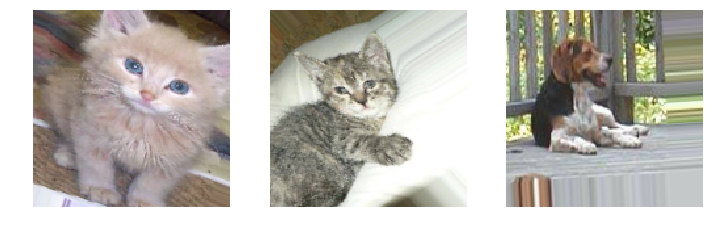

In [6]:
import matplotlib.pyplot as plt

%matplotlib inline

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
for img, label in train_generator:
    print(label[:3])
    ax[0].imshow(img[0])
    ax[0].axis('off')
    ax[1].imshow(img[1])
    ax[1].axis('off')
    ax[2].imshow(img[2])
    ax[2].axis('off')
    break
plt.show()

### 训练模型

In [7]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['acc'])

In [8]:
history = model.fit_generator(train_generator, 
                              steps_per_epoch=125, epochs=50, 
                              validation_data=validation_generator, validation_steps=60)

Epoch 1/50
125/125 [==============================] - 16s 127ms/step - loss: 1.7125 - acc: 0.7510 - val_loss: 0.6209 - val_acc: 0.8917
Epoch 2/50
125/125 [==============================] - 13s 104ms/step - loss: 0.5924 - acc: 0.8175 - val_loss: 0.3150 - val_acc: 0.8979
Epoch 3/50
125/125 [==============================] - 13s 103ms/step - loss: 0.4134 - acc: 0.8270 - val_loss: 0.3214 - val_acc: 0.8760
Epoch 4/50
125/125 [==============================] - 13s 103ms/step - loss: 0.3892 - acc: 0.8320 - val_loss: 0.2278 - val_acc: 0.8979
Epoch 5/50
125/125 [==============================] - 13s 104ms/step - loss: 0.3906 - acc: 0.8360 - val_loss: 0.2238 - val_acc: 0.9094
Epoch 6/50
125/125 [==============================] - 13s 105ms/step - loss: 0.3848 - acc: 0.8365 - val_loss: 0.2068 - val_acc: 0.9177
Epoch 7/50
125/125 [==============================] - 13s 103ms/step - loss: 0.3146 - acc: 0.8600 - val_loss: 0.2099 - val_acc: 0.9198
Epoch 8/50
125/125 [==============================] - 1

### 模型性能

查看模型训练过程中的`loss`和`acc`

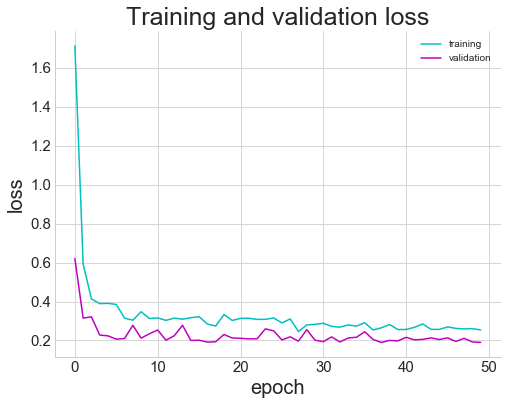

In [9]:
import seaborn as sns

# 设置图形参数
sns.set_style("whitegrid",  {'axes.grid' : False})

sns.set_context(rc={'axes.titlesize': 25, 'axes.labelsize': 20,
                    'xtick.labelsize': 15, 'ytick.labelsize': 15})
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure(figsize=(8, 6))
plt.plot(epochs, loss, 'c', label='training')
plt.plot(epochs, val_loss, 'm', label='validation')
sns.despine()
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.show()

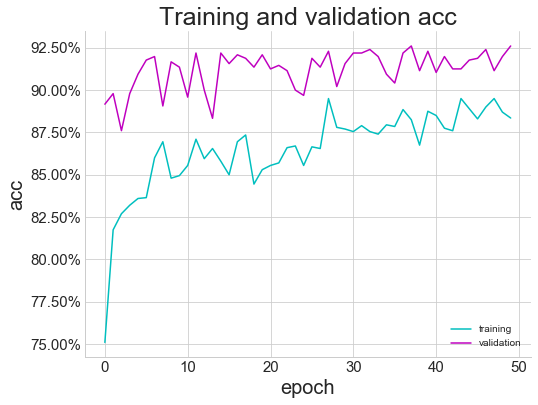

In [10]:
from matplotlib.ticker import FuncFormatter

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.figure(figsize=(8, 6))
plt.plot(epochs, acc, 'c', label='training')
plt.plot(epochs, val_acc, 'm', label='validation')
sns.despine()
plt.grid()
plt.yticks()
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation acc')
plt.show()

整个训练过程中可以看到，验证集的性能整体还不错，但是通过训练和验证的曲线可以发现，验证集的性能要好于训练集的性能，这在深度学习中偶尔会发生，有兴趣的话，可以搜索其中的原因

再来查看下模型在测试集上的性能

In [11]:
test_generator = test_data_generator.flow_from_directory(
    directory='cats_and_dogs/test/',
    target_size=(150, 150),
    batch_size=16,
    class_mode='binary'
)

test_loss, test_acc = model.evaluate_generator(test_generator)
print('Test loss: {}\nTest acc: {}%'.format(round(test_loss, 4), round(test_acc * 100, 2)))

Found 1000 images belonging to 2 classes.
Test loss: 0.1876
Test acc: 92.7%


准确率达到了92.7%，模型的性能看来还不错

### 测试模型

最后，我们读入一张猫的图片测试一下模型

Prediction: CAT


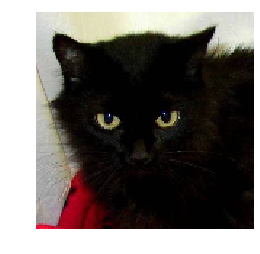

In [13]:
import numpy as np
from tensorflow.keras.preprocessing import image

test_image = image.load_img('cats_and_dogs/test/cats/cat.1500.jpg', 
                            target_size=(150, 150))
X = image.img_to_array(test_image)
X = X[np.newaxis, :, : , :]
X = X / 255

result = model.predict(X)
print("Prediction: {}".format('DOG' if result > 0.5 else 'CAT'))
plt.imshow(test_image)
plt.axis('off')
plt.show()

模型成功识别出了猫